### Clustering-based automated reading and decryption of the fairy ciphertext in children's book _Artemis Fowl and the Arctic Incident_ by Eoin Colfer
<img src="bookcover.jpg" width="20%" align="right" style='margin: 0px 0px 0px 20px' >
This wonderful kids' series is fun not only for the stories themselves, but also because each of the first several books involves a cipher puzzle with "fairy hieroglyphics".  I love code puzzles!<P>  
  
Originally in the first book the hieroglyphics were sequenced across the bottoms of the pages, and after manually decrypting a few pages with the key from the story it got tedious and I forgot about it for a while.  But then I read my son the next book in the series in electronic form, where I discovered the hieroglyphic sequence was moved to the back of the book, all perfectly lined up in matrices over a few pages at the end.  And I thought, hey that seems like it'd be easy to parse and decrypt on a computer, just like the main character did.

It has worked out moderately well so far.  My original plan was to use frequency-analysis and/or an iterative algorithm using dictionary comparison to auto-decrypt the glyphs (after they were converted to numbers) without the cipher key.  (Some refs I was looking at are [this paper](http://cse.ucdenver.edu/~rhilton/docs/Cryptanalysis-Against-Monosub-Ciphers.pdf) and [this python package](http://practicalcryptography.com/cryptanalysis/stochastic-searching/cryptanalysis-simple-substitution-cipher/#python-code)).  But before getting farther with that I've simply manually entered the key from the book.  The glyph recognition and parsing is still all automated, which is why the result isn't perfect at the end - in particular there remain some missing letters that were considered noise by the clustering; maybe some further tuning could improve that.  But it's enough to read the message!

Here's a docker container I found on DockerHub that made it easy to get the notebook going in jupyter:  

    > docker run -v ~/Documents:/home/jovyan/work -p 8888:8888 jupyter/tensorflow-notebook:latest

And then you can just paste the localhost:8888 browser link from the commandline into your browser.  
Next the boilerplate of python package imports that I used...

In [69]:
import os
import string

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import PIL.Image
import sklearn.cluster
from sklearn.cluster import KMeans
from sklearn.preprocessing import scale
import enchant  # install with `pip install pyenchant`

# from my unfinished further playing:
# import nltk  # pip install nltk
# from nltk.corpus import words
# nltk.download('words')

print("There were four pages (the image files here) of fairy glyphs, plus one page with the key:")
print(sorted([filename for filename in os.listdir() if '.PNG' in filename]))
print("Img_2003 is the code key image - hopefully can solve without it, but it's here just in case...")

There were four pages (the image files here) of fairy glyphs, plus one page with the key:
['IMG_1998.PNG', 'IMG_1999.PNG', 'IMG_2001.PNG', 'IMG_2002.PNG', 'IMG_2003.PNG']
Img_2003 is the code key image - hopefully can solve without it, but it's here just in case...


.  
  
This following sequence reads the images of glyphs, and breaks then first into individual rows and then into individual glyphs in the order they appear in the ciphertext.

In [5]:
glyphlist = []
pages = []
rows = np.empty([0,1])
all_glyphs = np.empty((0,630))  # 630 = 21*30 which came from the maxx,maxy below

# extract the rows of glyphs from the four images of many-glyphs-per-many-rows-per-image
for filename in ["IMG_1998.PNG", "IMG_1999.PNG", "IMG_2001.PNG", "IMG_2002.PNG"]:
    img = PIL.Image.open(filename)
    w, h = img.size
    img = img.crop((0, 200, w, h))  # crop off non-glyph page top (200 based on visual inspection)

    page = np.array(img.convert(mode='L'))
    pages.append(page)
    rows = np.append(rows, np.split(page, np.where(page.mean(axis=1) > 254)[0]))

# extract the individual glyphs from each row
for row in rows:
    if len(row) > 1:
        # split each row into separate glyphs
        glyphs = np.split(row, np.where(row.mean(axis=0)>254)[0], axis=1)
        for glyph in glyphs:
            if glyph.shape[1] > 1 and (255-glyph).sum().sum()>100:
                glyphlist.append(glyph)

# zero-pad all the glyphs so their arrays are all same size/shape, and flatten glyphs to vectors
maxy = max([glyph.shape[0] for glyph in glyphlist])
maxx = max([glyph.shape[1] for glyph in glyphlist])
for glyph in glyphlist:
    paddedglyph = np.ones((maxy, maxx)) * 255
    paddedglyph[0:glyph.shape[0], 0:glyph.shape[1]] = glyph
    all_glyphs = np.vstack([all_glyphs, paddedglyph.flatten()])

print("maxx,maxy: (", maxx,maxy, "),  all_glyphs.shape:", all_glyphs.shape)

maxx,maxy: ( 30 21 ),  all_glyphs.shape: (2646, 630)


.  
  
Here we see how the mean of each image row shows us where we can split apart the rows.  (Same approach is then used to split apart the glyphs.)  Note the mean intensity=1 rows are all whitespace, and the low mean intensity rows are where the black glyphs are.  The way the split works, the whitespace rows end up all being 1 pixel high (those get filtered out by the "len(row) > 1" conditionals), and the glyph rows end up being more than that (like about 21 high).  But you can see how this method relies on the precisely laid-out format of the glyphs in these matrices.

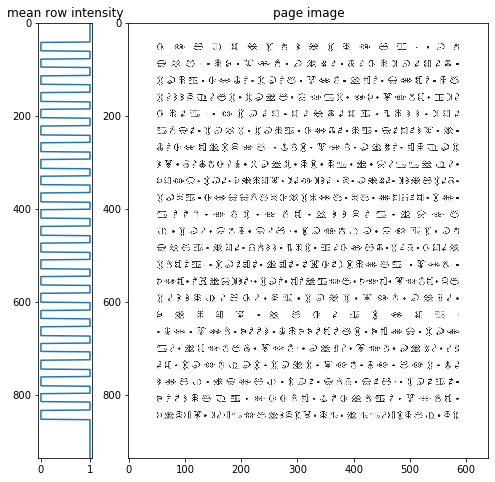

In [7]:
fig,ax = plt.subplots(1, 2, figsize=(10, 8))
ax[0].plot(pages[0].mean(axis=1)>254, range(pages[0].shape[0]))
ax[0].set_title("mean row intensity")
ax[0].set_ylim([0, pages[0].shape[0]])
ax[0].invert_yaxis()
ax[0].set_position([0.125, 0.125, 0.2-0.125, 0.88-0.125])
im = PIL.Image.fromarray(np.uint8(cm.gray(pages[0])*255))
ax[1].set_title("page image")
ax[1].imshow(im, aspect="auto")
ax[1].set_position([0.25, 0.125, 0.5, 0.88-0.125])

Here's an example of what the rows look like...

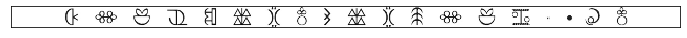

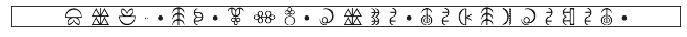

In [308]:
for row in rows[:70]:
    if len(row) > 1:
        im = PIL.Image.fromarray(np.uint8(cm.gray(row)*255))
        fig,ax = plt.subplots(figsize=(12, 2))
        ax.imshow(im)
        ax.set_xticks([])
        ax.set_yticks([])

And then the individual glyphs, split into a list of 2D numpy arrays the same way, and reshaped to vectors (but back to 2D for the plots).

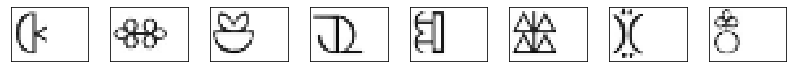

In [8]:
fig,axes = plt.subplots(1, 8, figsize=(14, 1))
for glyph, ax in zip(all_glyphs[:8], axes.flat):
        im = PIL.Image.fromarray(glyph.reshape((21, 30)))
        ax.imshow(im)
        ax.set_xticks([])
        ax.set_yticks([])

So now let's cluster that list of over 2600 glyphs into the known number of possible characters (29, admittedly known from the key, so the 26 alphabet characters plus space, period, and comma).  Then use the clusters to label each glyph, and that becomes our ciphertext we can work with further.

In [10]:
# scale or don't scale the glyph vectors before clustering - seemed better without
do_scale = False
if do_scale:
    X = scale(all_glyphs)
else:
    X = all_glyphs

# DBSCAN definitely seemed to work better for this than the others; all were pretty sensitive to param choice.
# ciphertext = KMeans(init='k-means++', n_clusters=29, n_init=10).fit(X).labels_
# ciphertext = sklearn.cluster.AgglomerativeClustering(n_clusters=29).fit(X).labels_
ciphertext = sklearn.cluster.DBSCAN(eps=350, min_samples=10).fit(X).labels_  # finds its own # clusters

print("len(ciphertext):", len(ciphertext))

len(ciphertext): 2646


Let's look at how well the clustering did on the glyphs here.  If the clustering worked perfectly there would be exactly 29 labels, one for each letter plus comma, period, and space from the key, and all elements in each cluster would be the same symbol.  But there are slight variations in the glyphs from the text (even from its electronic form - maybe due to image compression?) and the clustering is not perfect, which we'll see below.  But DBSCAN with these parameters worked better than the other clustering algorithms I tried above.  An additional handy thing about this algorithm is that rerunning it reproduces the same answer.  All the algorithms had difficulty distinguishing the comma (few dots) from the period (several dots) glyphs and mixed them together.

Label number used in the ciphertext is at far left


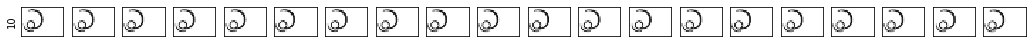

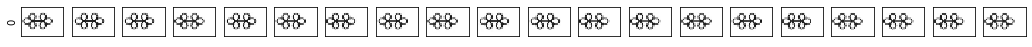

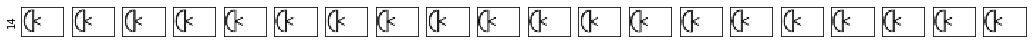

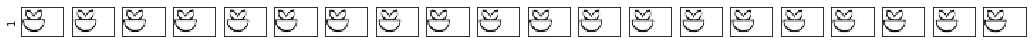

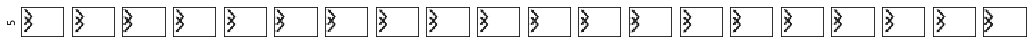

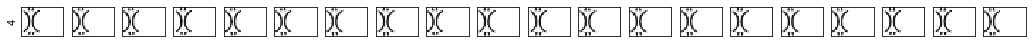

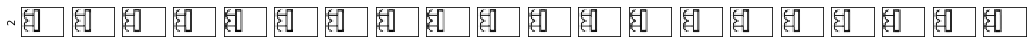

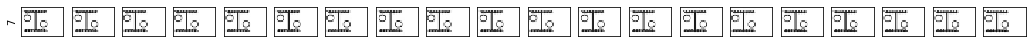

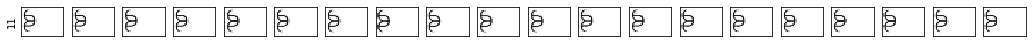

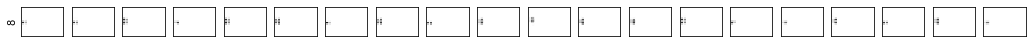

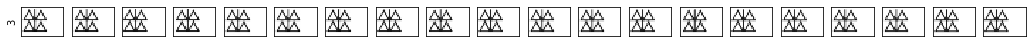

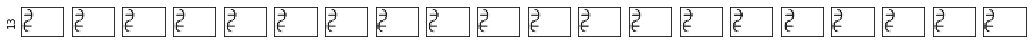

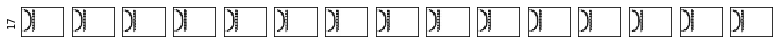

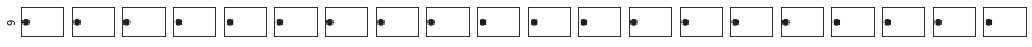

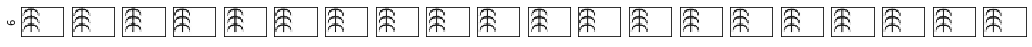

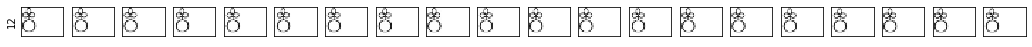

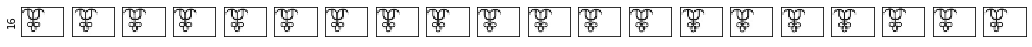

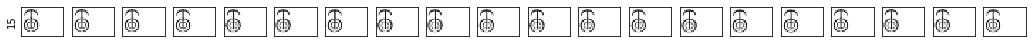

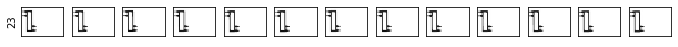

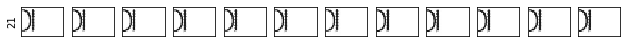

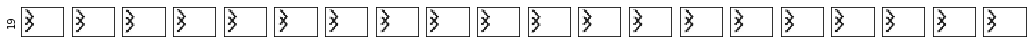

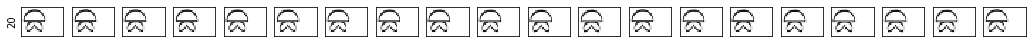

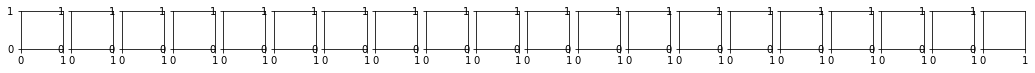

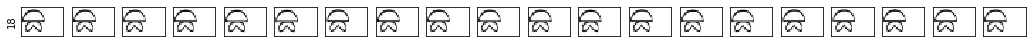

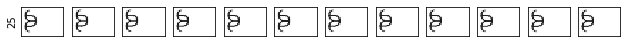

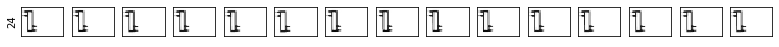

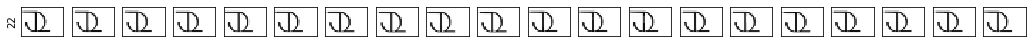

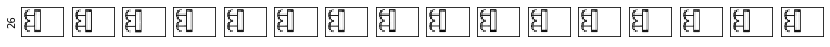

In [70]:
# we're going to plot approx 30 rows (number of labels from clustering), which is > 20
# so will trigger a warning that we're not worried about, so turn it off:
plt.rcParams.update({'figure.max_open_warning': 0})

numperrow = 20
for i in mykey.label:
    fig,axes = plt.subplots(1, numperrow, figsize=(18, 0.7))
    for j, glyph, ax in zip(range(numperrow), all_glyphs[ciphertext==i][:numperrow], axes.flat):
        im = PIL.Image.fromarray(glyph.reshape((21, 30)))
        ax.imshow(im)
        ax.set_xticks([])
        ax.set_yticks([])
        if j==0:
            ax.set_ylabel(i)
    if j<numperrow-1:
        for k, ax in zip(range(numperrow), axes.flat):
            if k > j:
                ax.set_visible(False)
                
print('Label number used in the ciphertext is at far left.')
print('Only plotting first 20 glyphs in each cluster but note many clusters have hundreds of glyphs...')

.  

Now we group the glyphs by their cluster labels (integers) to find the letter frequencies.

In [29]:
unique_elements, counts_elements = np.unique(ciphertext, return_counts=True)
codekey = pd.DataFrame(np.asarray(counts_elements).transpose(), columns={'freq'})
codekey["label"] = codekey.index
codekey.head().style.hide_index()

freq,label
341,0
183,1
121,2
93,3
130,4


The hope here is that we can use the standard English letter frequencies and see how readily we can come up with a method to converge onto the actual cipher.  From Wikipedia entry on cryptanalysis frequency analysis:
"Given a section of English language, E, T, A and O are the most common, while Z, Q and X are rare. Likewise, TH, ER, ON, and AN are the most common pairs of letters (termed bigrams or digraphs), and SS, EE, TT, and FF are the most common repeats. The nonsense phrase 'ETAOIN SHRDLU' represents the 12 most frequent letters in typical English language text."

...Ok that ended up getting more involved than planned.  Still want to look into some of the automated methods mentioned at top of page, but meanwhile let's bring up the key and use it to substitute characters based on the rows of glyphs above.

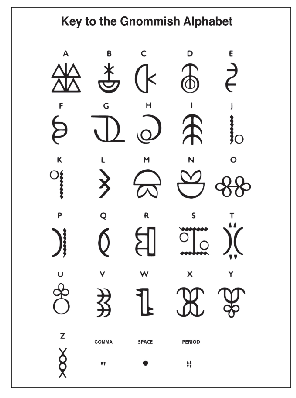

In [71]:
img = PIL.Image.open('IMG_2003.PNG')
w, h = img.size
img = img.crop((0, 230, w, h-70))  # crop off non-glyph page areas (230  & 70 based on visual inspection)
fig,ax = plt.subplots(1, 1, figsize=(5, 7))
ax.imshow(img, aspect="auto")
ax.set_xticks([])
ax.set_yticks([]);

In [72]:
mykey = codekey.sort_values(by="freq", ascending=False)
mykey = mykey.reset_index(drop=True)
# started with 'ETAOIN SHRDLU' but that appeared to be way off, may due to funny fairy-story wording.
freqorderlist = list("HOCNLTRSF,AEP IUYDWPLM_MFWGR")  # ultimately I just manually came up with this from key

# add remainder of alphabet not used in freqorderlist
transtable = str.maketrans(dict.fromkeys(freqorderlist))
remaininglist = string.ascii_uppercase.translate(transtable)
freqorderlist.extend(remaininglist)

# set the current code key to this cipher
mykey['cipher'] = pd.Series([letter.lower() for letter in freqorderlist])
mykeydict = mykey[['label','cipher']].set_index('label').to_dict()['cipher']
mykey.head().style.hide_index()

freq,label,cipher
476,10,h
341,0,o
241,14,c
183,1,n
163,5,l


In [73]:
# Apply current cipher (in mykeydict) to the ciphertext to generate candidate plaintext.
# The "noise" labels from DBSCAN are initially -1 which end up as nans here, so replacing those with "_"...
mykeydict[-1] = "_"
plaintext = [mykeydict[letter] for letter in ciphertext]
plaintext = ['_' if x is np.nan else x for x in plaintext]
plaintext = ''.join(plaintext).split()

In [74]:
def print_wraplines(wordlist, linelength=90):
    """Just a pretty-printer to make the plaintext easier to read in paragraph form below."""
    line = []
    for word in wordlist:
        line.append(word)
        if len(' '.join(line)) < linelength:
            continue
        else:
            print(' '.join(line))
            line = []
    print(' '.join(line))

The immediate output is generally readable, with our minds filling in the words that have underscores in them.  These were the letters in the ciphertext that the DBSCAN clustering labeled as "noise".  I'm still not sure why the clustering had so much difficulty labeling those several main stretches of glyphs...

In [77]:
print_wraplines(plaintext)

_ongrat_lations, hu_an, if you ha_e deciphe_ed this co_e then yo_ are more intelligent than
most of your spe_ies, other readers wi_l presume that _h_s code is merely a _eco_ation, _ut
you ha_e rightly deduced that it is a message from the fa_ry _eople, i ha_e planted this comm_nication
in order to see_ o_t our allies among the mud men, though most humans are dull wit second ted
creatures, there are e_cept_on_, you, for e_am_e, the _eason for your intelligence is that
you ha_e _____ _________, _o you feel different from those around you, ha_e you ha_e e_er thou_ht
that you do not _elong among the mu_ men, these feelin_s occu_ _ecause yo_r fa_ry personal_ty
is as_e_ting itself, if you a_e pale s_inne_ an_ _pend an _nor_ina_e amount of time on the
toilet, then your fore_a_he_ w_s pro___ly a sun _hy, gas _enting dwarf, if your ton_ue _s o_
_uf_icient length to touch your nose, then you are de_cended f_om _he go_lin race, _o_lins
ha_e no eyel___, and _herefore must lic_ their eye_alls to _e

Ok, so not the most literary material there, ah well what to do.  :-)
  
Next we can try some heuristical methods to simply clean that up a bit - at least fixing most of the single underscore dropout words:

In [75]:
d = enchant.Dict("en_US")
new_plaintext = []
for word in plaintext:    
    if '_' in word:
        if "," in word:
            hascomma = True
        else:
            hascomma = False
        word = word.replace(",", "")
        d2 = [w for w in d.suggest(word) if (len(w)==len(word) and "'" not in w and w.islower())]
        if d2:
            newword = d2[0]
        else:
            newword = word
        if newword == "hake":
            newword = "have"
        if hascomma:
            newword = newword + ","
            
        new_plaintext.append(newword)
    else:
        new_plaintext.append(word)

In [76]:
print_wraplines(new_plaintext)

congratulations, human, if you have deciphered this code then you are more intelligent than
most of your species, other readers will presume that _h_s code is merely a evacuation, out
you have rightly deduced that it is a message from the fairy people, i have planted this communication
in order to seer oat our allies among the mud men, though most humans are dull wit second ted
creatures, there are receipting, you, for reamer, the reason for your intelligence is that
you have _____ _________, co you feel different from those around you, have you have ever thought
that you do not belong among the mud men, these feelings occur because your fairy personality
is asserting itself, if you ace pale s_inne_ any spend an _nor_ina_e amount of time on the
toilet, then your fore_a_he_ was pro___ly a sun shy, gas denting dwarf, if your tongue as oh
sufficient length to touch your nose, then you are descended from she goblin race, _o_lins
have no eyel___, and therefore must lick their eyeballs to be

.  
  
Still not perfect to be sure, but pretty neat to get that far in a mostly-automated method.  I sure as heck wasn't going to sit down and substitute every one of those glyphs with pencil and paper.  (...well ok I might have; I've been known to do it before!)  Definitely curious to try some of those automated cipheranalysis routines mentioned at top of page sometime...